<a href="https://colab.research.google.com/github/abiflynn/data_analysis_python/blob/main/data_exploration/quality_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quality Assessment


In [1]:
import pandas as pd

Load our cleaned DataFrames

In [2]:
# orders_cl.csv
url = "https://drive.google.com/file/d/1Tla62vfu__kCqvgypZyVt2S9VuC016yH/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orders_cl = pd.read_csv(path)

# orderlines_cl.csv
url = "https://drive.google.com/file/d/1OhtkQS2fwOYdzfd-qPh7im35iLc-L9TA/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines_cl = pd.read_csv(path)

# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing" 
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

## 1.&nbsp; Define Pandas display format

In [3]:
#pd.set_option("display.float_format", lambda x: "%.2f" % x)
pd.set_option("display.max_rows", 1000)

## 2.&nbsp; Exclude unwanted orders

### Include only actual purchases
No `shopping cart`, `cancelled` etc...

In [4]:
actual_purchases_df = orders_cl.copy()

In [5]:
actual_purchases_df

,order_id,created_date,total_paid,state
0,241319,2017-01-02 13:35:40,44.99,Cancelled
1,241423,2017-11-06 13:10:02,136.15,Completed
2,242832,2017-12-31 17:40:03,15.76,Completed
3,243330,2017-02-16 10:59:38,84.98,Completed
4,243784,2017-11-24 13:35:19,157.86,Cancelled
...,...,...,...,...
226899,527397,2018-03-14 13:56:38,42.99,Place Order
226900,527398,2018-03-14 13:57:25,42.99,Shopping Basket
226901,527399,2018-03-14 13:57:34,141.58,Shopping Basket
226902,527400,2018-03-14 13:57:41,19.98,Shopping Basket


In [6]:
actual_purchases_df.state.value_counts()

Shopping Basket    117809
Completed           46605
Place Order         40883
Pending             14374
Cancelled            7233
Name: state, dtype: int64

In [7]:
actual_purchases_df = actual_purchases_df.loc[actual_purchases_df['state'].isin(["Completed"]), :]

In [8]:
actual_purchases_list = list(actual_purchases_df["order_id"])

In [9]:
orders_qu = orders_cl.loc[orders_cl["order_id"].isin(actual_purchases_df["order_id"]), :].copy()

In [10]:
orderlines_qu = orderlines_cl.loc[orderlines_cl["id_order"].isin(actual_purchases_list), :].copy()

### Keep only the orders that are present in both `orders` and `orderlines`

In [11]:
len(list(orders_qu.order_id.unique()))

46605

In [12]:
len(list(orderlines_qu.id_order.unique()))

43064

Approximately 3000 difference. I'll perform an inner merge on the two tables using the `order_id` & `id_order`. This will then keep only the `order_id`'s that are present in both tables, which will then help us filter our `_qu` DataFrames once again.

In [13]:
orders_lines_merged_df = orders_qu.merge(orderlines_qu, how="inner", left_on="order_id", right_on="id_order")

In [15]:
orders_lines_merged_df.head()

,order_id,created_date,total_paid,state,id,id_order,product_id,product_quantity,sku,unit_price,date
0,241423,2017-11-06 13:10:02,136.15,Completed,1398738,241423,0,1,LAC0212,129.16,2017-11-06 12:47:20
1,242832,2017-12-31 17:40:03,15.76,Completed,1529178,242832,0,1,PAR0074,10.77,2017-12-31 17:26:40
2,243330,2017-02-16 10:59:38,84.98,Completed,1181923,243330,0,1,OWC0074,77.99,2017-02-15 17:07:44
3,245275,2017-06-28 11:35:37,149.00,Completed,1276706,245275,0,1,TAD0007,149.00,2017-06-28 11:12:30
4,245595,2017-01-21 12:52:47,112.97,Completed,1154394,245595,0,2,PAC1561,52.99,2017-01-21 12:49:00


In [16]:
o_ids_in_both_list = list(orders_lines_merged_df["order_id"].unique())

In [17]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(o_ids_in_both_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_cl["id_order"].isin(o_ids_in_both_list), :]

In [18]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))

(43064, 43064)

## 3.&nbsp; Exclude orders with unknown products


In [21]:
products_cl.head()

,sku,name,desc,price,in_stock,type
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,0,13855401
2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,0,1387
3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,0,1230
4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pr...,34.99,1,1364


In [22]:
known_skus_list = list(products_cl["sku"])

Let's have a look to see how many products in our `orderlines_qu` DataFrame are known and how many are unknown.

In [24]:
orderlines_qu.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date
6,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16
7,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34
8,1119120,295347,0,1,APP0700,72.19,2017-01-01 01:54:11
15,1119134,299556,0,1,CRU0039-A,60.90,2017-01-01 02:20:14
21,1119145,299561,0,1,PEB0015,142.49,2017-01-01 02:38:50


In [25]:
orderlines_qu.sku.isin(known_skus_list).value_counts()

True     55320
False     1394
Name: sku, dtype: int64

Looks like the vast majority of products are known. 

I can't simply delete the rows containing unknown products. I need to remove the entirety of any order that contains an unknown product. 

The 1st step is to identify any order that contains an unknown product. Then find the `order_id` of these orders. Finally filter these order numbers out of our `_qu` DataFrames.

In [26]:
orders_with_unknown_products_list = list(orderlines_qu.loc[~orderlines_qu.sku.isin(known_skus_list), "id_order"])

Now I can filter our DataFrame to exclude the `order_id`'s that contain unknown products

In [27]:
orders_qu = orders_qu.loc[~orders_qu["order_id"].isin(orders_with_unknown_products_list), :]
orderlines_qu = orderlines_qu.loc[~orderlines_qu["id_order"].isin(orders_with_unknown_products_list), :]

In [29]:
orders_qu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41701 entries, 1 to 226614
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      41701 non-null  int64  
 1   created_date  41701 non-null  object 
 2   total_paid    41701 non-null  float64
 3   state         41701 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.6+ MB


In [30]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))

(41701, 41701)

In [32]:
orderlines_qu.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54324 entries, 6 to 215949
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                54324 non-null  int64  
 1   id_order          54324 non-null  int64  
 2   product_id        54324 non-null  int64  
 3   product_quantity  54324 non-null  int64  
 4   sku               54324 non-null  object 
 5   unit_price        54324 non-null  float64
 6   date              54324 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.3+ MB


## 4.&nbsp; Explore the revenue from different tables

In [33]:
orderlines_qu_copy = orderlines_qu.copy()

#### Step 1:
Create the `unit_price_total` as `orderlines.unit_price` * `orderlines.product_quantity`

In [34]:
orderlines_qu_copy["unit_price_total"] = orderlines_qu_copy["product_quantity"] * orderlines_qu_copy["unit_price"]

#### Step 2: 
Group by `order_id`, summarising by the sum of `unit_price_total`

In [35]:
orderlines_qu_group_order_df = orderlines_qu_copy.groupby("id_order", as_index=False)["unit_price_total"].sum()

### What is the average difference between `total_paid` and `unit_price_total`?

In [36]:
orders_qu_copy = orders_qu.copy()

Merge the grouped `orderlines` table with the `orders` table, so we can calculate the differences in prices.

In [37]:
diff_df = orders_qu_copy.merge(orderlines_qu_group_order_df, left_on="order_id", right_on="id_order")

In [39]:
diff_df["difference"] = diff_df["total_paid"] - diff_df["unit_price_total"]
diff_df.head()

,order_id,created_date,total_paid,state,id_order,unit_price_total,difference
0,241423,2017-11-06 13:10:02,136.15,Completed,241423,129.16,6.99
1,242832,2017-12-31 17:40:03,15.76,Completed,242832,10.77,4.99
2,243330,2017-02-16 10:59:38,84.98,Completed,243330,77.99,6.99
3,245275,2017-06-28 11:35:37,149.00,Completed,245275,149.00,0.00
4,245595,2017-01-21 12:52:47,112.97,Completed,245595,105.98,6.99


In [40]:
diff_df.difference.mean().round(2)

4.47

### What is the distribution of these differences?

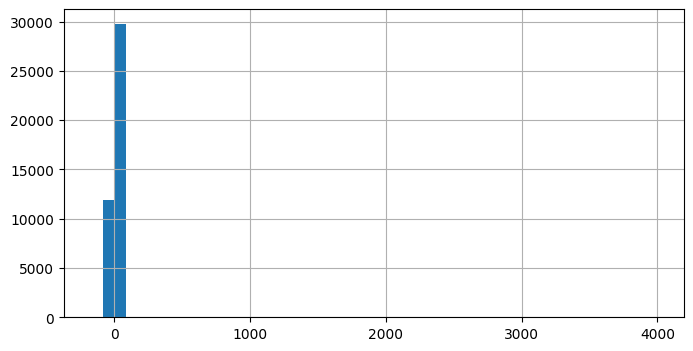

In [41]:
diff_df.difference.hist(bins= 50, figsize=(8,4));

In [42]:
diff_df.difference.describe()

count    41701.000000
mean         4.474808
std         26.046478
min       -165.000000
25%          0.000000
50%          4.990000
75%          6.990000
max       3984.990000
Name: difference, dtype: float64

### Can all the differences be explained by shipping costs? If not, what are other plausible explanations?

What reasons have you come up with to explain the difference?

### If there are differences that you can’t explain: what should you do with these orders?
There's a rule of thumb, that anything: 
+ lower than the 25% quartile - (1.5 x interquartile range), or 
+ higher than the 75% quartile + (1.5 x interquartile range) 

is an outlier. Let's use this rule to try and exclude any corrupted data.

In [43]:
# calculate the quartiles
Q1 = diff_df["difference"].quantile(0.25)
Q3 = diff_df["difference"].quantile(0.75)

# calculate the interquartile range
IQR = Q3-Q1

# filter the DataFrame to include only "non-outliers"
diff_no_outliers_df = diff_df.loc[(diff_df["difference"] >= (Q1 - 1.5*IQR)) & (diff_df["difference"] <= (Q3 + 1.5*IQR)), :]

Let's look at the distribution again to see the affect of removing the outliers.

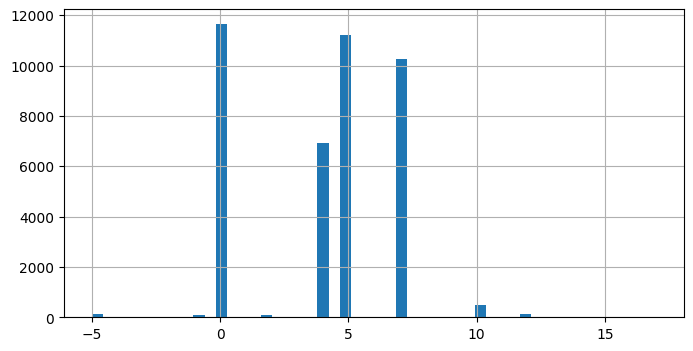

In [45]:
diff_no_outliers_df.difference.hist(bins= 50, figsize=(8,4));

This looks much more like what we would expect: a small difference, but nothing extreme.

Now we need to remove these orders with extreme differences from our `orders_lines_merged` DataFrame.

In [46]:
diff_no_outliers_df.describe()

,order_id,total_paid,id_order,unit_price_total,difference
count,40985.000000,40985.000000,40985.000000,40985.000000,40985.000000
mean,414728.336416,194.673066,414728.336416,190.733302,3.939763
std,65935.016747,250.508266,65935.016747,251.330549,2.834176
min,241423.000000,2.820000,241423.000000,2.490000,-5.000000
25%,362317.000000,46.980000,362317.000000,41.970000,0.000000
50%,417508.000000,98.040000,417508.000000,94.050000,4.990000
75%,470672.000000,244.990000,470672.000000,240.330000,6.990000
max,527112.000000,6876.940000,527112.000000,6876.800000,16.970000


In [47]:
normal_diff_list = list(diff_no_outliers_df["order_id"])

In [48]:
orders_qu = orders_qu.loc[orders_qu["order_id"].isin(normal_diff_list), :]
orderlines_qu = orderlines_qu.loc[orderlines_cl["id_order"].isin(normal_diff_list), :]

In [49]:
len(list(orders_qu["order_id"].unique())), len(list(orderlines_qu["id_order"].unique()))

(40985, 40985)